## SGD for FM [STEFFEN RENDLE]
* 目标函数
$$\hat{y} = w_0 + \sum_{j=1}^{p}w_jx_j+\frac{1}{2}\sum_{f=1}^{k}[(\sum_{j=1}^{p}v_{j,f}x_j)^2-\sum_{j=1}^{p}v_{j,f}^2x_j^2]$$

* 加入正则项，防止过拟合
* Algorithm for SGD
![](img_fm/3.png)
* Gridents
$$\frac{\partial}{\partial\theta}l^{LS}(\hat{y}(\vec{x}|\vec{\theta},y)) = \frac{\partial}{\partial\theta}(\hat{y}(\vec{x}|\vec{\theta})-y)^2 = 2(\hat{y}(\vec{x}|\vec{\theta})-y)\frac{\partial}{\partial\theta}\hat{y}(\vec{x}|\vec{\theta})$$
![](img_fm/4.png)

* Little tip for Numpy and sparse matrix
> numpy's dot function does not have native support for handling sparse matrices. What is happening is numpy thinks of the sparse matrix C as a python object

### load data

In [32]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import math
import matplotlib.pyplot as plt
# Read in data
def loadData(filename,path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

### 使用SGD训练FM

In [37]:
# -*- coding: utf-8 -*-
import numpy as np
import math


class FM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg_w,
                 reg_v,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg_w = reg_w

        self.reg_v = reg_v

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = 0

        # feature bias
        self.W = 0

        # feature
        self.V = 0

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # global bias
        self.w0 = np.sum(np.random.rand(1, 1))  # bias

        # feature bias
        self.W = np.random.rand(1, p)

        # feature
        self.V = np.random.rand(p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx, :]
            y_train = y_[reidx]

            for i in xrange(n):

                if self.verbose and i % 10000 == 0:
                    print 'processing ' + str(i) + 'th sample...'

                X = X_train[i, :]
                y = y_train[i]

                # too slow
                #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                X = X.toarray()

                tmp = np.sum(X.T * self.V, axis=0)
                factor_part = (np.sum(tmp * tmp) - np.sum(
                    (X.T*X.T)*(self.V * self.V))) / 2
                y_predict = self.w0 + np.sum(np.dot(self.W, X.T)) + factor_part

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict - y
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                self.w0 -= self.learning_rate * (2 * diff * 1 + 2*self.reg_w*self.w0)

                # update W
                self.W -= self.learning_rate * (2 * diff * X + 2*self.reg_w*self.W)

                # update V
                self.V -= self.learning_rate * (2 * diff * (
                    X.T * (np.dot(X, self.V) - X.T * self.V)) + 2 * self.reg_v * self.V)

    def validate(self, X_, y_):
        (n, p) = X_.shape

        mse = []
        loss_sgd = []

        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_[i, :]
            y = y_[i]

            # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V), axis=0)
            factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                (X.T.multiply(X.T)).multiply(np.multiply(self.V, self.V)))) / 2
            y_predict = self.w0 + self.W * X.T + factor_part

            #                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict - y
            loss_sgd.append(math.pow(diff, 2))

            # update mse
            mse.append(sum(loss_sgd) / len(loss_sgd))
        return mse

In [54]:
import time
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)

start = time.time()
fm_sgd = FM_SGD(iter_num=1,
               learning_rate=0.01,
               factors_num=10,
               reg_w=0.01,
               reg_v = 0.001)
fm_sgd.train(X_train,y_train)
print '---%s seconds---' %(time.time() - start)

processing 0th sample...
processing 10000th sample...
processing 20000th sample...
processing 30000th sample...
processing 40000th sample...
processing 50000th sample...
processing 60000th sample...
processing 70000th sample...
processing 80000th sample...
processing 90000th sample...
---209.798000097 seconds---


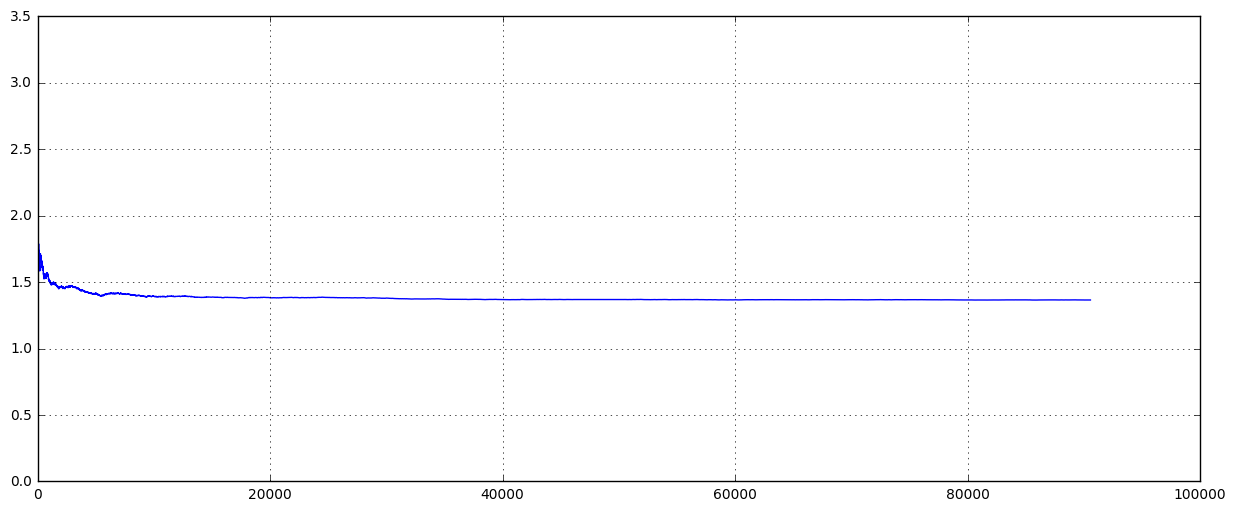

In [10]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_sgd.mse)

### 使用ADAGRAD 训练FM

* SGD的弊端在于使用了一个恒定的全局的学习速率，无法根据feature的gradient更新速率来动态调整更新学习速率
* 为了解决这一弊端，我们为每一个参数维护一个学习速率，随着迭代次数的增加，根据总的gradient来更新学习速率

In [ ]:
class FM_ADAGRAD():
    
    def __init__(self,
                iter_num,
                learning_rate,
                factors_num,
                reg,
                verbose = True):
        
        # 迭代次数
        self.iter_num = iter_num
        
        #学习速率
        self.learning_rate = learning_rate
        
        # 分解器feature个数
        self.factors_num = factors_num
        
        # lambda
        self.reg = reg
        
        # 输出执行信息
        self.verbose = verbose
        
        # global bias
        self.w0 = 0;
        
        # feature bias
        self.W = 0;
        
        # feature
        self.V = 0;
        
        # 训练过程中的mse
        self.mse = []
        
        # target y的最大值与最小值，for prune
        self.y_max = 0.0;
        self.y_min = 0.0;
        
        
    def train(self, X_, y_):
        
        (n,p) = X_.shape
        
        self.mse = []
        
        # global bias
        self.w0 = sum(np.random.rand(1))  # bias
        
        # feature bias
        self.W = np.random.rand(1,p)
        
        # feature
        self.V = np.random.rand(p,self.factors_num)
        
        self.y_max = np.max(y_)
        self.y_min = np.min(y_)
        
        # keep track of all parameters 
        w0_gradients = 0.0;
        W_gradients = np.zeros((1,p))
        V_gradients = np.zeros((p,self.factors_num))
        
        # avoid 0 numerator
        epison = 1e-8
        
        for j in xrange(self.iter_num):
            
            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx,:]
            y_train = y_[reidx]

            

            for i in xrange(n):

                if self.verbose and i%1000 ==0:
                    print 'prossing ' + str(i) + 'th sample...'

                X = X_train[i,:]
                y = y_train[i]

                # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                tmp = np.sum(X.T.multiply(self.V),axis=0)
                factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
                y_predict = self.w0 + np.sum(self.W*X.T) + factor_part
                
#                 print y_predict

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict-y
                loss_sgd.append(math.pow(diff,2))

                # update mse
                self.mse.append(sum(loss_sgd)/len(loss_sgd))

                # update w0
                gradient = 2*diff * (1)
                w0_gradients += np.square(gradient)
                self.w0 = self.w0 - self.learning_rate/np.sqrt(w0_gradients+epison)*gradient
                
                
                # update W
                gradient = 2*diff * (X)
                W_gradients += gradient.multiply(gradient)
                self.W = self.W - gradient.multiply(self.learning_rate/np.sqrt(W_gradients+epison))
                
#                 print W_gradients.shape
#                 print gradient.shape
                
                
                
                # update V
                gradient = 2*diff* (X.T.multiply((np.tile(X*self.V,(p,1)) - X.T.multiply(self.V))))
                V_gradients += np.multiply(gradient,gradient)
                self.V = self.V - np.multiply(self.learning_rate/np.sqrt(V_gradients+epison),gradient)
                

    def validate(self, X_, y_):
        (n,p) = X_.shape
        
        mse = []
        

        for i in xrange(n):

            if self.verbose and i%1000 ==0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_train[i,:]
            y = y_train[i]

            # too slow
        #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V),axis=0)
            factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
            y_predict = self.w0 + np.sum(self.W*X.T) + factor_part

#                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict-y
            loss_sgd.append(math.pow(diff,2))

            # update mse
            mse.append(sum(loss_sgd)/len(loss_sgd))
        return mse

In [ ]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
fm_adagrad = FM_ADAGRAD(iter_num=1,
               learning_rate=0.1,
               factors_num=10,
               reg=0.1)
fm_adagrad.train(X_train,y_train)

In [ ]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_adagrad.mse)

In [ ]:
fm_adagrad.W

## Local Linear Factorization Machines

In [58]:
# -*- coding: utf-8 -*-
import math

import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans


class LLFM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg_w,
                 reg_v,
                 anchor_num,
                 neighbor_num,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg_w = reg_w

        self.reg_v = reg_v

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = 0

        # feature bias
        self.W = 0

        # feature
        self.V = 0

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

        # anchor point 的个数
        self.anchor_num = anchor_num

        # find k-nearest anchor points
        self.neighbor_num = neighbor_num

        # anchor point
        self.anchor_points = np.array([0])

    def knn(self, x):
        dist = np.linalg.norm(self.anchor_points - x, axis=1)
        idx = np.argsort(dist)
        dist = np.exp(-dist[idx[:self.neighbor_num]])
        gamma = dist / np.sum(dist)
        return gamma, idx[:self.neighbor_num]

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # anchor bias
        self.w0 = 0.1*np.random.rand(self.anchor_num, 1)

        # feature bias
        #         self.W = np.random.rand(1,p)
        # local coding
        self.W = 0.1*np.random.rand(self.anchor_num, p)

        # feature
        self.V = 0.1*np.random.rand(self.anchor_num, p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        if self.verbose:
            print 'performing K-means...'

        # K-means get anchor points

        kmeans = KMeans(n_clusters=self.anchor_num, random_state=0).fit(X_)

        # mini batch
#         kmeans = MiniBatchKMeans(n_clusters=self.anchor_num, random_state=0).fit(X_)
        self.anchor_points = kmeans.cluster_centers_

        if self.verbose:
            print 'K-means done...'

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            re_idx = np.random.permutation(n)
            x_train = X_[re_idx, :]
            y_train = y_[re_idx]

            for i in xrange(n):

                if self.verbose and i % 1000 == 0:
                    print 'processing ' + str(i) + 'th sample...'

                X = x_train[i, :]
                y = y_train[i]

                (gamma, idx) = self.knn(X)

                X = X.toarray()

                # if self.verbose:
                #     print 'k-nearest neighbors found...'

                # reshape V to 2-dimension

                # V = self.V[idx, :, :].reshape(self.neighbor_num*p, self.factors_num)

                # X_repmat = np.tile(X.toarray(), (self.neighbor_num, 1))

                factor_part = 0.0

                for k in xrange(self.neighbor_num):
                    tmp = np.sum(X.T * self.V[k], axis=0)

                    factor_part += gamma[k] * (np.sum(tmp * tmp) - np.sum(
                        (X.T * X.T) * (self.V[idx[k]] * self.V[idx[k]]))) / 2

                y_predict = np.sum(
                    np.dot(np.array([gamma]), self.w0[idx, :]) + np.dot(np.array([gamma]),
                                                                        np.dot(self.W[idx, :], X.T)) + factor_part)

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = np.sum(y_predict - y)
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                self.w0[idx, :] -= np.dot(gamma, self.learning_rate * (2 * diff * 1 + 2 * self.reg_w * self.w0[idx, :]))

                # update W
                self.W[idx, :] -= np.dot(gamma, self.learning_rate * (2 * diff * X + 2 * self.reg_w * self.W[idx, :]))

                # update V
                for k in xrange(self.neighbor_num):
                    self.V[idx[k]] -= gamma[k] * self.learning_rate * (2 * diff * (
                        X.T * (np.dot(X, self.V[idx[k]]) - X.T * self.V[idx[k]])) + 2 * self.reg_v * self.V[idx[k]])

    def validate(self, x_, y_):
        (n, p) = x_.shape

        mse = []
        loss_sgd = []

        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                print 'processing ' + str(i) + 'th sample...'

            x = x_[i, :]
            y = y_[i]

            tmp = np.sum(x.T.multiply(self.V), axis=0)
            factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                (x.T.multiply(x.T)).multiply(np.multiply(self.V, self.V)))) / 2
            y_predict = self.w0 + np.sum(self.W * x.T) + factor_part

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict - y
            loss_sgd.append(math.pow(diff, 2))

            # update mse
            mse.append(sum(loss_sgd) / len(loss_sgd))
        return mse


In [65]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
start_time = time.time()

llfm_sgd = LLFM_SGD(iter_num=1,
                    learning_rate=0.01,
                    factors_num=10,
                    reg_w=0.01,
                    reg_v=0.001,
                    anchor_num=100,
                    neighbor_num=20
                    )
llfm_sgd.train(X_train, y_train)

#
# fm_sgd = FM_SGD(iter_num=1,
#                 learning_rate=0.01,
#                 factors_num=10,
#                 reg=0.1)
# fm_sgd.train(X_train, y_train)
print '----%s seconds-----' % (time.time() - start_time)

performing K-means...
K-means done...
processing 0th sample...
processing 1000th sample...
processing 2000th sample...
processing 3000th sample...
processing 4000th sample...
processing 5000th sample...
processing 6000th sample...
processing 7000th sample...
processing 8000th sample...


KeyboardInterrupt: 

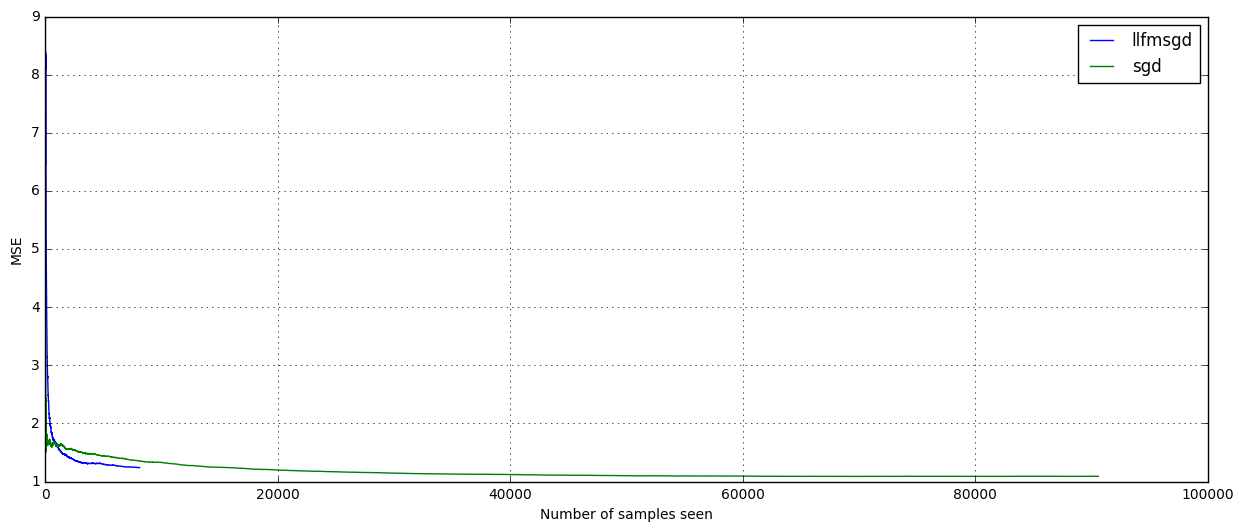

In [66]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(llfm_sgd.mse)
plt.plot(fm_sgd.mse)
plt.legend(['llfmsgd','sgd'])
plt.xlabel('Number of samples seen')
plt.ylabel('MSE')
plt.show()

In [92]:
a = np.ones((10000,10))
b = 2*np.ones((1,2000))

In [67]:
llfm_sgd.mse

[9.0,
 6.5,
 5.666666666666667,
 4.25,
 5.2,
 4.5,
 6.142857142857143,
 5.5,
 5.888888888888889,
 6.2,
 6.454545454545454,
 7.25,
 6.769230769230769,
 6.928571428571429,
 7.533333333333333,
 7.625,
 8.117647058823529,
 7.888888888888889,
 8.31578947368421,
 8.327499776080383,
 8.326063430277948,
 8.092145322597968,
 8.378177186300455,
 8.151178356512613,
 7.94092510618665,
 7.740008009560328,
 7.9374552908629346,
 7.872717047455993,
 8.022636749076973,
 7.824408057911547,
 7.581256501052215,
 7.524782719540746,
 7.35235790125574,
 7.297967006518585,
 7.244138357233094,
 7.344659809457964,
 7.186203273032916,
 7.122186767741711,
 6.971169296302544,
 6.812369131032115,
 6.666004362381884,
 6.507705636395986,
 6.357548788955087,
 6.443275183607071,
 6.526407939516392,
 6.47616191572849,
 6.35860095248651,
 6.244068844263825,
 6.3006041246387205,
 6.352707690762308,
 6.390091812645633,
 6.334903135254968,
 6.2280125897395395,
 6.1277922464996015,
 6.017288005030266,
 6.04590381101836,
 5.9

In [68]:
fm_sgd.mse

[6.856942056176824,
 3.438243143442474,
 2.292162453145543,
 3.31013472309255,
 2.90347400117611,
 2.4245669338463016,
 3.759430645992191,
 3.399966881011868,
 3.1333038942327716,
 2.9199735048094944,
 2.714297924809514,
 2.4963955407953717,
 2.3121576813160973,
 2.1481723649669395,
 2.017381347827521,
 1.8937888910725509,
 2.1358721893913155,
 2.0477712838218554,
 1.9474664776773736,
 1.8607738114377583,
 1.9110879368289584,
 1.824841007020832,
 2.4411522675851436,
 2.3874607037969873,
 2.3533483394789427,
 2.406557154190403,
 2.3311724207548155,
 2.2481872789964616,
 2.1779965570622437,
 2.1235062320868967,
 2.102623499188207,
 2.0484832995925983,
 1.9963680875569125,
 1.988210980803173,
 1.9846044794604711,
 2.116131631627485,
 2.058989121501166,
 2.006104596175612,
 1.9557518285510151,
 1.9244115853841772,
 1.9062771202178226,
 1.8647210884043568,
 1.8571967451032512,
 1.8149932902419046,
 1.7748142714313297,
 1.7368125207246947,
 1.7131806049451077,
 1.7032568210696029,
 1.6789950

In [17]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
kmeans = KMeans(n_clusters=100, random_state=0).fit(X_train)

In [18]:
kmeans.inertia_

150969.98689071694

In [19]:
a = np.array([[1,2]])
b = np.array([[2],[1]])

In [21]:
np.dot(a,b).shape

(1L, 1L)

In [28]:
a = np.array([[[1,2]],
              [[3,4]]
             ])

In [29]:
a[0]

array([[1, 2]])

In [27]:
a.reshape(2,2)

array([[1, 2],
       [3, 4]])